In [1]:
#import the necessary libraries
import pandas as pd
import os
import seaborn as sns


# The Problem
### I keep losing my fantasy baseball league!

My fantasy baseball league has been going for more than 7 years now, and I've only won it once. Some of the problems that I've run into are things like a lack of preparation for the draft, and falling behind on hard to predict categories for players, such as "Wins" for pitchers.

Here, I do a top-down exploratory modeling and analysis to help practice my data science skills, and uncover some insights that will help me dominate the league for years to come. Someone call Billy Beane.


# Phase 1 - Predicting pitcher wins and examing correlations
Here, I build a model to predict pitcher wins. I use data from a each pitcher in a prepared baseball database (http://www.seanlahman.com/) to try to predict how many wins they would end up with that year. This would be a little fuzzy for predicting _future_ Wins, but we'll cross that bridge eventually. Here, I want to see how accurately we can guess wins if we have all of the information for that year.

In [2]:
#take a look at what we have to explore
!ls

AllstarFull.csv                     Managers.csv
Appearances.csv                     ManagersHalf.csv
AwardsManagers.csv                  Parks.csv
AwardsPlayers.csv                   People.csv
AwardsShareManagers.csv             Pitching.csv
AwardsSharePlayers.csv              PitchingPost.csv
Batting.csv                         Salaries.csv
BattingPost.csv                     Schools.csv
CollegePlaying.csv                  SeriesPost.csv
Fielding.csv                        Teams.csv
FieldingOF.csv                      TeamsFranchises.csv
FieldingOFsplit.csv                 TeamsHalf.csv
FieldingPost.csv                    predicting_pitcher_wins-Copy1.ipynb
HallOfFame.csv                      predicting_pitcher_wins.ipynb
HomeGames.csv                       readme2014.txt


In [3]:
#import the pitchers data and take a look at it
pitchers = pd.read_csv('Pitching.csv')
pitchers.tail()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
45801,youngch03,2017,1,KCA,AL,0,0,14,2,0,...,2.0,1,1.0,0,148.0,5,27,0.0,0.0,3.0
45802,zastrro01,2017,1,CHN,NL,0,0,4,0,0,...,0.0,0,1.0,0,62.0,0,13,0.0,0.0,3.0
45803,zieglbr01,2017,1,MIA,NL,1,4,53,0,0,...,6.0,1,6.0,0,211.0,21,29,3.0,0.0,10.0
45804,zimmejo02,2017,1,DET,AL,8,13,29,29,0,...,2.0,3,7.0,0,713.0,0,111,3.0,8.0,19.0
45805,zychto01,2017,1,SEA,AL,6,3,45,0,0,...,3.0,1,5.0,1,173.0,7,12,1.0,2.0,5.0


In [4]:
#look at what all the features we have are
pitchers.columns

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP'],
      dtype='object')

In [5]:
#I want to predict wins, so I set my target as the Wins column in our data frame
y = pitchers.W

#I then delete the Wins column because I don't want to train on the data I'm trying to predict
del pitchers['W']
pitchers.fillna(0)

#I want to get one-hot variables for categorical things like League and Team
#but if I leave the PlayerID in there, I will have thousands of one-hot columns that are meaningless
#it will make the data take too long to work with and doesn't add anything (that I can think of)
del pitchers['playerID']
#now that I have deleted player ID values, I can get dummy variables
one_hot = pd.get_dummies(pitchers)


In [6]:
#I'm going to need to validate our model, so let's use the train_test_split function
#here I import the necessary function
from sklearn.model_selection import train_test_split

#let's take a look at the columns again to make sure I didn't create way too many one-hot dummy variables
one_hot.columns

Index(['yearID', 'stint', 'L', 'G', 'GS', 'CG', 'SHO', 'SV', 'IPouts', 'H',
       ...
       'teamID_WS7', 'teamID_WS8', 'teamID_WS9', 'teamID_WSU', 'lgID_AA',
       'lgID_AL', 'lgID_FL', 'lgID_NL', 'lgID_PL', 'lgID_UA'],
      dtype='object', length=181)

In [7]:
#split the dataset 80/20 for training/testing
X_train, X_test, y_train, y_test = train_test_split(one_hot, y, test_size = .2, random_state=42)


In [8]:
#import the necessary library to create our model
from xgboost import XGBRegressor

#define the model. I arbitrarily selected the number of trees to fit and the learning rate
model = XGBRegressor(n_estimators=124, learning_rate=0.05)


In [9]:
#fit the model
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=124,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [10]:
#make predictions about the test set
predictions = model.predict(X_test)

#we want to know how well we predicted number of wins, so we will import a function to measure mean absolute error.
from sklearn.metrics import mean_absolute_error
print("MAE is "+ str(mean_absolute_error(predictions, y_test)))

MAE is 1.1135217059298754


In [46]:
#if we're predicting within about 1 game, that's a pretty good prediction.
#let's see if we can make it better with more trees

estim = [100,150,200,250,300,350]
lrs = [0.005, 0.01, 0.05, 0.1]
for num in estim:
    for lr in lrs:
        model = XGBRegressor(n_estimators=num, learning_rate=lr)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print("MAE is "+ str(mean_absolute_error(predictions, y_test)))

MAE is 2.863752402799459
MAE is 1.9979518873316573
MAE is 1.1351495600474035
MAE is 1.070456321278245
MAE is 2.363627120013243
MAE is 1.5638966722158958
MAE is 1.093505686360841
MAE is 1.0509768749748456
MAE is 2.0011811579478618
MAE is 1.3558994526654657
MAE is 1.0737698770127582
MAE is 1.0402742041963282
MAE is 1.7453338602853379
MAE is 1.2571272953150965
MAE is 1.061709391634242
MAE is 1.036213462229406
MAE is 1.5655714268345833
MAE is 1.2068773532207813
MAE is 1.0534068274298913
MAE is 1.0321441693835267
MAE is 1.4424967050122997
MAE is 1.1789399568748589
MAE is 1.0487031088115295
MAE is 1.0301027851082878


In [1]:
#Obviously, there's room for improvement. We improved from 1.113 to 1.030
#One issue to consider: I didn't shuffle the training set before doing this. Fortunately, train_test_split does this
#by default

#we always kept going down, so it seems we haven't overfit
# lrs = [0.1, 0.5, 1.0]
# estim = [350,400,450]

# for num in estim:
#     for lr in lrs:
#         model = XGBRegressor(n_estimators=num, learning_rate=lr)
#         model.fit(X_train, y_train)
#         predictions = model.predict(X_test)
#         print("MAE is "+ str(mean_absolute_error(predictions, y_test)))

In [ ]:
#the model started getting worse when we went up to 0.5 with the learning rate
#so we'll stick with 0.1 - we could narrow this down farther
#but this is a primarily academic exercise at this point


In [50]:
lrs = [0.1]
estim = [400,450,500,550]

for num in estim:
    for lr in lrs:
        model = XGBRegressor(n_estimators=num, learning_rate=lr)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print("MAE is "+ str(mean_absolute_error(predictions, y_test)))

MAE is 1.0280941753499608
MAE is 1.0270967173657024
MAE is 1.0256665427041767
MAE is 1.0250265147358901


Cool! We built a model that can predict the Wins a pitcher will have, with reasonable accuracy. But what does that mean? Which of the factors in our dataset even correlate with Wins? Let's try to visualize it.

In [2]:
import seaborn as sns


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


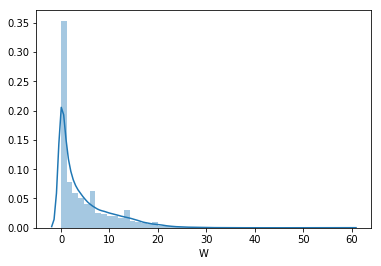

In [7]:
sns.distplot(pitchers.W)
#The distribution of wins for each pitcher in our dataset. The distribution is heavily skewed to the left
#We could consider removing relief pitchers from the analysis, but they can form an important 
#supplementary source of wins over the course of a season.

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


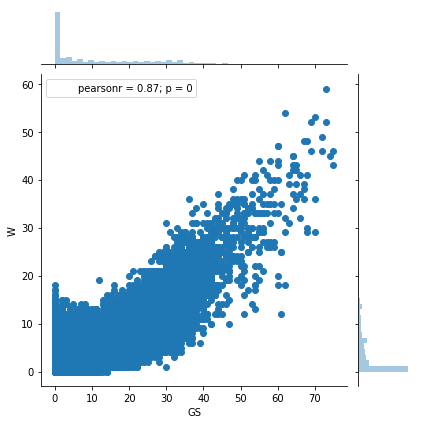

In [10]:
sns.jointplot(pitchers.GS, pitchers.W, kind=)
#let's try to make a scatter plot, showing the relationship of a given variable to pitcher wins

#I think wins is going to be correlated with the number of games started
#so let's use that as a demonstration.


In [8]:
pitchers.columns

Index(['yearID', 'stint', 'teamID', 'lgID', 'L', 'G', 'GS', 'CG', 'SHO', 'SV',
       'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp', 'ERA', 'IBB', 'WP',
       'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP'],
      dtype='object')

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


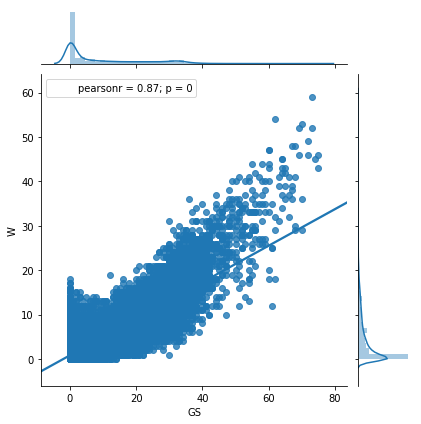

In [14]:
#That's pretty neat, but let's plot the regression line on top, so we can see how well correlated starts and wins are.
#of course, we could just look at the R value, but that's not nearly as fun.

sns.jointplot(pitchers.GS, pitchers.W, kind='reg')

That was an exercise to look at _one_ value that I predicted would be correlated. But let's examine all of the factors we have in the database. I want to know if any surprising correlations stick out.

In [23]:
#computer a correlation matrix for all of the variables
corr = pitchers.corr()

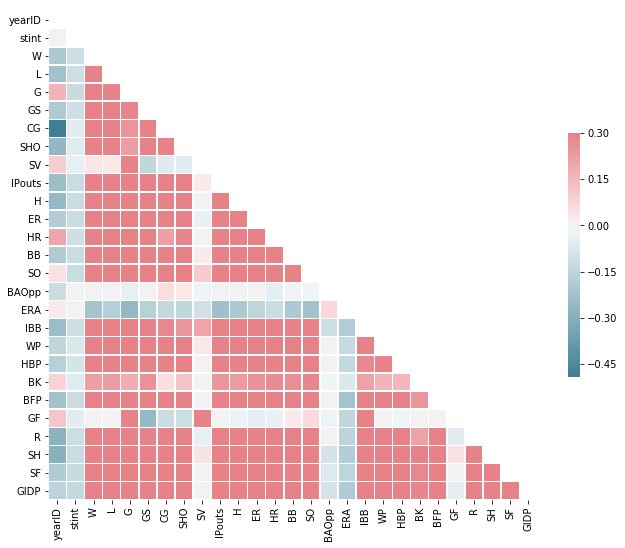

In [16]:
#Here I'm trying out a cool graph that I saw in a tutorial. While it looks neat, it doesn't actually 
#give all the information that I'm interested in

import numpy as np
import matplotlib.pyplot as plt

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Something that stands out is that Complete Games (CG) is negatively correlated with the year. This supports evidence to the idea that the style of the game is indeed changing. Relief pitchers are more heavily relied upon, and it's much less common to pitch a complete game now.

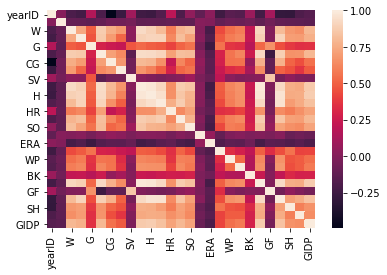

In [26]:
sns.heatmap(corr)

In [28]:
#the chart is also cool, but we really want to see an ordered list of the numbers.
#Specifically, I'm interested in Wins
corr.W.sort_values()

ERA      -0.218576
yearID   -0.194690
stint    -0.108002
GF        0.000747
BAOpp     0.001794
SV        0.031900
BK        0.220020
IBB       0.434618
G         0.493800
WP        0.549281
HR        0.595048
HBP       0.595922
SF        0.652800
SH        0.682008
SHO       0.692165
L         0.742020
CG        0.759968
BB        0.787018
GIDP      0.795870
R         0.809997
ER        0.810960
SO        0.823057
GS        0.872049
H         0.891407
BFP       0.914808
IPouts    0.934662
W         1.000000
Name: W, dtype: float64

There are several things that we should watch out for here, because we need to remember that correlation is definitely not causation.
For example, the number of runs and hits is correlated with wins, but that's more likely to be a product of a pitcher just being in the game for longer and pitching more innings than the idea that you'll win more if you give up more runs.
This is shown by the strong INVERSE correlation with earned run average. If you average the number of runs to the number of innings pitched, instead of a correlation you get an inverse correlation.

# Phase 2 - Scraping ESPN data
Now, we begin to work on the next phase of the project- using players as features to predict team success. 

We want to know which players are most predictive of a successful team. Ultimately, we would be able to tell if drafting a given player would make our team more like a winner. This would account for the fact that a winning team wouldn't have 5 first basemen, because you can only actually play 2 of them. Right now, in-draft tools just recommend the player with the best stats, not necessarily the best player to move your team towards being a winning team. 

An important start to this is actually getting the data.

In [11]:
#Since ESPN doesn't have an API anymore, and I've never done web scraping before, I spent some time testing
#how scraping works. Most of that has been removed in this notebook.

In [12]:
import requests

In [13]:
page = requests.get("http://games.espn.com/flb/clubhouse?leagueId=61029&teamId=7&seasonId=2018")
page

<Response [200]>

In [14]:
#page.content

In [15]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(page.content, 'html.parser')
print(soup.prettify())

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01//EN" "http://www.w3.org/TR/html4/strict.dtd">
<html>
 <head>
  <title>
   Sports BLT -  ESPN
  </title>
  <!-- N7-326:2315-->
  <meta content="text/html;charset=utf-8" http-equiv="Content-Type"/>
  <meta content="text/javascript" http-equiv="Content-Script-Type"/>
  <meta content="Play Fantasy Baseball for free on ESPN! Expert analysis, live scoring, mock drafts, and more." property="og:description">
   <meta content="http://g.espncdn.com/lm-static/flb17/images/share/facebook.png" property="og:image">
    <meta content="summary_large_image" name="twitter:card"/>
    <meta content="@ESPNFantasy" name="twitter:site"/>
    <meta content="ESPN Fantasy Baseball - Play For Free" name="twitter:title"/>
    <meta content="http://g.espncdn.com/lm-static/flb17/images/share/twitter.png" name="twitter:image"/>
    <meta content="no-cache" http-equiv="Pragma"/>
    <meta content="no-cache, must-revalidate, proxy-revalidate, maxage=0" http-equiv="Cache-Co

In [16]:
list(soup.children)

['HTML PUBLIC "-//W3C//DTD HTML 4.01//EN" "http://www.w3.org/TR/html4/strict.dtd"',
 '\n',
 <html>
 <head>
 <title>Sports BLT -  ESPN</title>
 <!-- N7-326:2315-->
 <meta content="text/html;charset=utf-8" http-equiv="Content-Type"/>
 <meta content="text/javascript" http-equiv="Content-Script-Type"/>
 <meta content="Play Fantasy Baseball for free on ESPN! Expert analysis, live scoring, mock drafts, and more." property="og:description">
 <meta content="http://g.espncdn.com/lm-static/flb17/images/share/facebook.png" property="og:image">
 <meta content="summary_large_image" name="twitter:card"/>
 <meta content="@ESPNFantasy" name="twitter:site"/>
 <meta content="ESPN Fantasy Baseball - Play For Free" name="twitter:title"/>
 <meta content="http://g.espncdn.com/lm-static/flb17/images/share/twitter.png" name="twitter:image"/><meta content="no-cache" http-equiv="Pragma"/>
 <meta content="no-cache, must-revalidate, proxy-revalidate, maxage=0" http-equiv="Cache-Control"/>
 <meta content="-1" http

In [17]:
[type(item) for item in list(soup.children)]


[bs4.element.Doctype,
 bs4.element.NavigableString,
 bs4.element.Tag,
 bs4.element.NavigableString]

In [18]:
html = list(soup.children)[2]

Ok that's enough practice, I think I've finally figured out what's going on.

I need to write a function to gather all the URLS for a given league, then I need to feed those into another function.

In the second function, I have to find all the rows that have the class, "pncPlayerRow", as I found by looking at the ESPN website. For each of those rows, I pull out the strings to get player neames. 

Because sometimes it will find a row without a player in that slot, I have to use try...except, in which case I include an NaN value.

In [42]:
# import numpy as np
# import requests
# from bs4 import BeautifulSoup
# import pandas as pd

league_url = 'http://games.espn.com/flb/history?leagueId=61029'

def get_2018_team_pages(league_url):
    ###takes the url of your league and returns a list of the team rankings/names/info 
    #and a list of urls for the teams###
    
    page = requests.get(league_url)

    soup = BeautifulSoup(page.content, 'html.parser')
    
    team_rows = []
    urls = []
    #loop that finds the rows in the table with each team, and retrieves the information and links
    for x in range(1,11):
        row = soup.find('tr' ,{'id' : [f'2018_rankRow{x}']})
        string = row.stripped_strings
        team_rows.append(list(string))
    
        col = row.findAll('a')
        urls.append(col[0]['href'])
    
    #convert urls to full urls
    full=[]
    for x in urls:
        full.append('http://games.espn.com'+x)
    return full, team_rows

#get the urls for all the teams in the league
league_urls ,league_teams = get_2018_team_pages(league_url)
print(league_urls,league_teams)

['http://games.espn.com/flb/clubhouse?leagueId=61029&teamId=7&seasonId=2018', 'http://games.espn.com/flb/clubhouse?leagueId=61029&teamId=3&seasonId=2018', 'http://games.espn.com/flb/clubhouse?leagueId=61029&teamId=10&seasonId=2018', 'http://games.espn.com/flb/clubhouse?leagueId=61029&teamId=6&seasonId=2018', 'http://games.espn.com/flb/clubhouse?leagueId=61029&teamId=1&seasonId=2018', 'http://games.espn.com/flb/clubhouse?leagueId=61029&teamId=4&seasonId=2018', 'http://games.espn.com/flb/clubhouse?leagueId=61029&teamId=5&seasonId=2018', 'http://games.espn.com/flb/clubhouse?leagueId=61029&teamId=8&seasonId=2018', 'http://games.espn.com/flb/clubhouse?leagueId=61029&teamId=2&seasonId=2018', 'http://games.espn.com/flb/clubhouse?leagueId=61029&teamId=9&seasonId=2018'] [['1st', 'Sports BLT', '92'], ['2nd', 'Buxton Out the Bats', '84.5'], ['3rd', 'Carolina Mudcats', '69.5'], ['4th', "Joey's Vatos", '53'], ['5th', 'Piazza Lovers Pizza', '50'], ['6th', 'Tritown trumpettes', '48'], ['7th', 'Birmin

In [43]:
list(league_teams)

[['1st', 'Sports BLT', '92'],
 ['2nd', 'Buxton Out the Bats', '84.5'],
 ['3rd', 'Carolina Mudcats', '69.5'],
 ['4th', "Joey's Vatos", '53'],
 ['5th', 'Piazza Lovers Pizza', '50'],
 ['6th', 'Tritown trumpettes', '48'],
 ['7th', 'Birmingham Blernsballers', '46'],
 ['8th', 'Raleigh Sheepstealers', '43'],
 ['9th', 'Boca Bashers', '35'],
 ['10th', 'Team ReadytoPlayCF', '29']]

In [49]:
import numpy as np

import requests
from bs4 import BeautifulSoup
import pandas as pd

url = 'http://games.espn.com/flb/clubhouse?leagueId=61029&teamId=7&seasonId=2018'

def players_on_team(url):
    ###takes a url from an ESPN fantasy baseball team page and returns the players on that team as a list
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')

    holder = []
    
    player_rows = soup.findAll('tr',{ 'class' : ['pncPlayerRow']})
    for x in player_rows:
        try:
            holder.append(list(x.find('a').stripped_strings))
        except:
            holder.append('N')

    return holder

list_of_players = players_on_team(url)
print(list_of_players)

[['Yasmani Grandal'], ['Edwin Encarnacion'], ['Jed Lowrie'], ['Jose Ramirez'], ['Trevor Story'], ['Mike Trout'], ['Christian Yelich'], ['Rhys Hoskins'], ['Aaron Hicks'], ['Chris Taylor'], ['Shin-Soo Choo'], ['Matt Carpenter'], 'N', ['Max Scherzer'], ['Corey Kluber'], ['Gerrit Cole'], ['Wade Davis'], ['Blake Snell'], ['Shane Greene'], ['Rich Hill'], ['Jeremy Jeffress'], ['Sean Manaea'], ['Michael Wacha']]


In [64]:
# Function to flatten the lists of lists into just lists

def flattener(list_of_lists):
    flattened_list=[]
    for x in list_of_lists:
        for y in x:
            flattened_list.append(y)
    return flattened_list


In [85]:
#pass the urls to the function
#get them back and take the resulting df's
#and concatenate them together

#initialize a list for the combined names for a given league
long_list = []
#initialize a list for the standings
lengths = []

#get the list of players in the league
for x in league_urls:
    list_of_players = players_on_team(x)
    flat_list = flattener(list_of_players)
    lengths.append(len(flat_list))
    long_list.append(flat_list)

#flatten the list of players
final_list = flattener(long_list)


In [99]:
#Expand the standings to match the length of players in each team
counter = 0
standings=[]
for x in lengths:
    counter+=1
    standings.append([counter]*x)

#standings is a list of lists, one list for each team, one entry for each player on the team of the place of that team
standings = flattener(standings)


231
231


In [100]:
#take the output and put it into a pandas dataframe, with one column as a team rank
#one column as team rank

df = pd.DataFrame({'players':final_list, 'standings':standings})

df.head()


,players,standings
0,Yasmani Grandal,1
1,Edwin Encarnacion,1
2,Jed Lowrie,1
3,Jose Ramirez,1
4,Trevor Story,1


In [101]:
df.tail()

,players,standings
226,Tyler Skaggs,10
227,Kenta Maeda,10
228,Ross Stripling,10
229,Andrew Heaney,10
230,Shohei Ohtani,10


In [69]:

#train the neural network on players as features and team rank as the prediction.
#be able to predict the rank given the players


#final step would be to 



#before this, implement a function to scrape multiple leagues
#next, take an espn league history and return the URL of the teams and their rank
#then find a way to crawl through all the league history pages
#finally, I could exclude leagues that are using different roto categories and leagues that have less than 10 teams.

# Next Steps:

I'm going to build a web-crawler to go through all the publicly available ESPN sites, (maybe make sure they use the same metrics as my league) and feed that information into my scraper pipeline to build a large dataset of the players that compose each team, and that team's rank.

Then, I'm going to make a neural network that treats each player as a feature, and attempt to predict team rank.

Finally, once I'm able to input a group of players and predict team rank, I want to be able to input one player and see how it changes a team's ranking. This would be my proposed project for Insight.